In [16]:
from torch.utils.data import TensorDataset, DataLoader
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns
plt.rcParams["axes.grid"] = False
matplotlib.rcParams['axes.linewidth'] = .75
from Models.actor import *
from Models.world import *
from stable_baselines3 import PPO

In [2]:
device = 'cpu'

In [36]:
# LOAD MODELS
world_network  = torch.load('Data/world_network.pth',map_location='cpu',weights_only=False)
actor_network  = torch.load('Data/actor_network.pth',map_location='cpu',weights_only=False)

In [46]:
# FUNCTION FOR GENERATING EXPERIENCE WITH AN ACTOR
def generate_experience(actor,env,NUM_EPISODES = 1000, MAX_STEPS = 100, device='cpu'):
    inputs = torch.zeros(NUM_EPISODES, 6)
    labels = torch.zeros(NUM_EPISODES, MAX_STEPS, 7)
    for episode in range(NUM_EPISODES):
        # Initialize new actor
    
        # Reset environment
        state = env.reset()
        # Reshape state variable
        state = torch.tensor(np.concatenate([state[0]['observation'], state[0]['desired_goal']])).float()

        inputs[episode, :] = state
    
        for step in range(MAX_STEPS):
            action = actor(state.to(device))
     
            # Take step in environment to get new state and reward
            new_state, reward, _, _, _ = env.step(action.detach().cpu().numpy())
            new_state = torch.tensor(np.concatenate([new_state['observation'], new_state['desired_goal']])).float()
    
            # Add data 

            labels[episode, step, :] = torch.hstack([state, torch.tensor(reward).float()])
    
            # Set current state to new state
            state = new_state.clone()
            
    inputs = inputs.to(device)
    labels = labels.to(device)
    return inputs, labels

In [47]:
# FUNCTION FOR ASSESSING WORLD MODEL'S ESTIMATE OF THE REWARD FUNCTION
def plot_reward_model(world_network,env,NUM_EPISODES = 100,MAX_STEPS = 1000):
    '''
    Plot the predicted reward for each state visited by actor in env
    :param world_network: World model 
    :param actor_network: Actor model
    :param env: Environment
    :return: Plot of predicted reward for each state
    '''
    world_network.N_STEPS = MAX_STEPS
    inputs,labels = generate_experience(world_network.actor_network,env,NUM_EPISODES = NUM_EPISODES,MAX_STEPS = MAX_STEPS)
    outputs = world_network.forward(inputs)
    rows = []
    for episode in range(outputs.shape[0]):
        for t in range(outputs.shape[1]):
            rows.append({'episode':episode,
                         't':t,
                         'x': outputs[episode,t,0].item(),
                         'y': outputs[episode,t,1].item(),
                         'reward': outputs[episode,t,-1].item(),})
            
    df = pd.DataFrame(rows)
    fig = plt.figure(figsize=(2.5, 2.5))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    sns.scatterplot(x='x',y='y',hue='reward',data=df,legend=False,alpha=.5,ax=ax,s=5)
    ax.set_xlim(-3.5,3.5)
    ax.set_ylim(-3.5,3.5)
    rect = matplotlib.patches.Rectangle((-3, -3), 6,6, linewidth=1, edgecolor='k', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     ax.xaxis.set_tick_params(labelsize=6,bottom=True)
#     ax.yaxis.set_tick_params(labelsize=6,left=True)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('', fontsize=8)
    ax.set_ylabel('', fontsize=8)

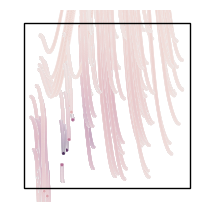

In [48]:
MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0,0,1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 'g', 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]]
env = gym.make('PointMaze_Medium-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'rgb_array'
)

world_network.device = 'cpu'
plot_reward_model(world_network,env)

In [56]:
# PLOT 2D TRAJECTORIES (REAL OR SIMULATED) IN ENVIRONMENT
def plot_model_trajectories(world_network,env,NUM_EPISODES =1000,MAX_STEPS = 100):
    inputs,labels = generate_experience(world_network.actor_network,env,NUM_EPISODES = NUM_EPISODES,MAX_STEPS = MAX_STEPS)
    outputs = world_network.forward(inputs)
    rows = []
    for episode in range(outputs.shape[0]):
        for t in range(outputs.shape[1]):
            rows.append({'episode':episode,
                         't':t,
                         'x': labels[episode,t,0].item(),
                         'y': labels[episode,t,1].item(),})
            
    df = pd.DataFrame(rows)
    fig = plt.figure(figsize=(2.5, 2.5))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    sns.scatterplot(x='x',y='y',hue='t',data=df,legend=False,alpha=.5,ax=ax,s=4)
    ax.set_xlim(-3.5,3.5)
    ax.set_ylim(-3.5,3.5)
    rect = matplotlib.patches.Rectangle((-3, -3), 6,6, linewidth=1, edgecolor='k', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     ax.xaxis.set_tick_params(labelsize=6,bottom=True)
#     ax.yaxis.set_tick_params(labelsize=6,left=True)
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlabel('', fontsize=8)
    ax.set_ylabel('', fontsize=8)

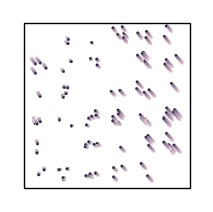

In [57]:
world_network.N_STEPS = 100
world_network.device = 'cpu'
plot_model_trajectories(world_network,env,NUM_EPISODES =100,MAX_STEPS = 100)

In [58]:
# SIMULATE ACTOR
def simulate_actor(actor_network,env,NUM_EPISODES=5,MAX_STEPS=100):
    for episode in range(NUM_EPISODES):
        
        if episode % 100==0:
            print(episode)
    
        
        # Imagined trajectory
        state = env.reset()
        state = torch.tensor(np.concatenate([state[0]['observation'], state[0]['desired_goal']])).float()
        #state = init_state
        for step in range(MAX_STEPS):
            env.render()
            action = actor_network(state)
            new_state, reward, _, _,_ = env.step(action.detach())
            state = torch.tensor(np.concatenate([new_state['observation'],new_state['desired_goal']])).float()
            #print(reward)
    env.close()

In [59]:
MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 'g', 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]]

# Initialize environment with this map for training.
env = gym.make('PointMaze_Medium-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'human'
)
simulate_actor(actor_network,env,NUM_EPISODES=25,MAX_STEPS=100)

0


2025-04-25 15:18:01.875 python[71895:4663159] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-25 15:18:01.875 python[71895:4663159] +[IMKInputSession subclass]: chose IMKInputSession_Modern
